# # Find out which spices are most commonly used in Indian cuisine

Indian food like most of the tropical food around the world uses lots of different spices. If you are planning to cook more Indian food, which spices should you buy? Analyzing multiple Indian recipes we can tabulate the frequency of various spices used and rank which spices are the most common ones. That way, you could invest, at start, only in those spices before considering to buy additional ones. 

To do this I found a dataset on Kaggle which has tabulated 6000+ recipes from https://www.archanaskitchen.com/. Using this as base collection of recipes representing most of the indian food, we can analyze which spices occur most freqeuntly. 

* Dataset for Indian recipe: This dataset 6000+ recipe scrapped from  | [Link to the dataset](https://www.kaggle.com/kanishk307/6000-indian-food-recipes-dataset)

In [1]:
import pandas as pd 
import numpy as np 

In [2]:
#----- PLOTTING PARAMS ----# 
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%config InlineBackend.figure_format = 'retina'
 
plot_params = {
'font.size' : 22,
'axes.titlesize' : 24,
'axes.labelsize' : 20,
#'lines.linewidth' : 3,
#'lines.markersize' : 10,
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,
}
 
plt.rcParams.update(plot_params)

### ### Read the dataset

In [7]:
food_df = pd.read_csv('./archive/IndianFoodDatasetCSV.csv')

In [8]:
food_df.columns

Index(['Srno', 'RecipeName', 'TranslatedRecipeName', 'Ingredients',
       'TranslatedIngredients', 'PrepTimeInMins', 'CookTimeInMins',
       'TotalTimeInMins', 'Servings', 'Cuisine', 'Course', 'Diet',
       'Instructions', 'TranslatedInstructions', 'URL'],
      dtype='object')

In [9]:
food_df.shape

(6871, 15)

In [10]:
# dropping miscellaneous columns 
columns_to_drop = ['CookTimeInMins', 'Servings', 'Course', 'Diet', 'Instructions', 'TranslatedInstructions', 'URL']
food_df = food_df.drop(columns = columns_to_drop).dropna()

In [11]:
# data has indian-inspired international cuisiones which are not what we are interested in
cuisines_to_drop = ['Mexican', 'Italian Recipes', 'Thai', 'Chinese', 'Asian', 'Middle Eastern', 'European',
                   'Arab', 'Japanese', 'Vietnamese', 'British', 'Greek', 'French', 'Mediterranean', 'Sri Lankan',
                   'Indonesian', 'African', 'Korean', 'American', 'Carribbean', 'World Breakfast', 'Malaysian', 'Dessert',
                   'Afghan', 'Snack', 'Jewish', 'Brunch', 'Lunch', 'Continental', 'Fusion']

food_df = food_df.loc[ ~ food_df['Cuisine'].isin(cuisines_to_drop) ] #Dropping entries in `food_df` which have following cuisines 

In [13]:
food_df.shape

(4881, 8)

In [14]:
food_df.head(5)

,Srno,RecipeName,TranslatedRecipeName,Ingredients,TranslatedIngredients,PrepTimeInMins,TotalTimeInMins,Cuisine
0,1,Masala Karela Recipe,Masala Karela Recipe,"6 Karela (Bitter Gourd/ Pavakkai) - deseeded,S...","6 Karela (Bitter Gourd/ Pavakkai) - deseeded,S...",15,45,Indian
1,2,टमाटर पुलियोगरे रेसिपी - Spicy Tomato Rice (Re...,Spicy Tomato Rice (Recipe),"2-1/2 कप चावल - पका ले,3 टमाटर,3 छोटा चमच्च बी...","2-1 / 2 cups rice - cooked, 3 tomatoes, 3 teas...",5,15,South Indian Recipes
2,3,Ragi Semiya Upma Recipe - Ragi Millet Vermicel...,Ragi Semiya Upma Recipe - Ragi Millet Vermicel...,"1-1/2 cups Rice Vermicelli Noodles (Thin),1 On...","1-1/2 cups Rice Vermicelli Noodles (Thin),1 On...",20,50,South Indian Recipes
3,4,Gongura Chicken Curry Recipe - Andhra Style Go...,Gongura Chicken Curry Recipe - Andhra Style Go...,"500 grams Chicken,2 Onion - chopped,1 Tomato -...","500 grams Chicken,2 Onion - chopped,1 Tomato -...",15,45,Andhra
4,5,आंध्रा स्टाइल आलम पचड़ी रेसिपी - Adrak Chutney ...,Andhra Style Alam Pachadi Recipe - Adrak Chutn...,"1 बड़ा चमच्च चना दाल,1 बड़ा चमच्च सफ़ेद उरद दाल,2...","1 tablespoon chana dal, 1 tablespoon white ura...",10,30,Andhra


In [15]:
# Some entries in the `TranslatedIngredients` have non-english entries 
def filter_english(string):
    try:
        string.encode('utf-8').decode('ascii')
        out = True
    except UnicodeDecodeError: 
        out = False
    return out

In [16]:
# Droping columns in the dataset having ingredients in language other than english 
df = food_df.loc[ food_df['TranslatedIngredients'].apply(filter_english) ]

In [17]:
df.shape

(4273, 8)

## ## Generate a consistent list of Indian spices for better tabulation

In [18]:
#read file of all indian spices on wikipedia
wiki_file_pd = pd.read_html('https://en.wikipedia.org/wiki/List_of_Indian_spices')
spices_list = wiki_file_pd[0]['Standard English'].copy().str.lower()

#some important spices to add
spices_to_add = pd.Series(['black mustard seed/raee', 'black salt', 'cumin powder', 'coriander leaves', 'green chillies', 'chili powder', 'ajwain/carom seeds/thymol', ])

#some spices are too common (such as pepper) or not a spice, but a vegetable, or are otherwise corrupted (for example,
#cardamom is often listed as "cardamom" nto specifying whether it is black or green)

spices_to_drop = ['black pepper', 'capers', 'chili pepper powder', 'cinnamon buds', 'garlic', 'capsicum',
                  'cumin seed ground into balls', 'dried ginger', 'green chili pepper', 'long pepper',
                  'indian bedellium tree', 'mango extract', 'coriander powder', 'saffron pulp', 'black cardamom', 'brown mustard seed', 'black cumin']

spices_list = spices_list[ ~spices_list.isin(spices_to_drop) ].append(spices_to_add).reset_index(drop=True)

In [19]:
#editing the spices so that my string counter can find different versions of the same spice
spices_list = spices_list.str.replace('amchoor', 'amchur/amchoor/mango extract') \
                    .replace('asafoetida', 'asafetida/asafoetida/hing') \
                    .replace('alkanet root', 'alkanet/alkanet root') \
                    .replace('chili powder', 'Chilli powder/kashmiri red chilli powder/chilli powder') \
                    .replace('celery / radhuni seed', 'celery/radhuni seed') \
                    .replace('bay leaf, indian bay leaf', 'bay leaf/bay leaves/tej patta') \
                    .replace('curry tree or sweet neem leaf', 'curry leaf/curry leaves') \
                    .replace('fenugreek leaf', 'fenugreek/kasoori') \
                    .replace('nigella seed', 'nigella/black cumin') \
                    .replace('ginger', 'dried ginger/ginger powder') \
                    .replace('cloves', 'cloves/laung') \
                    .replace('green cardamom', 'cardamom/black cardamom')\
                    .replace('indian gooseberry', 'indian gooseberry/amla')\
                    .replace('coriander seed', 'coriander seed/coriander powder')\
                    .replace('cumin powder', 'cumin powder/cumin seeds/cumin/jeera')

## ## Ingredients in the recipes

In [20]:
ingredients_series = df['TranslatedIngredients']

In [21]:
len(ingredients_series[ingredients_series.str.contains('hing')])

860

In [22]:
df.iloc[2]

Srno                                                                     3
RecipeName               Ragi Semiya Upma Recipe - Ragi Millet Vermicel...
TranslatedRecipeName     Ragi Semiya Upma Recipe - Ragi Millet Vermicel...
Ingredients              1-1/2 cups Rice Vermicelli Noodles (Thin),1 On...
TranslatedIngredients    1-1/2 cups Rice Vermicelli Noodles (Thin),1 On...
PrepTimeInMins                                                          20
TotalTimeInMins                                                         50
Cuisine                                               South Indian Recipes
Name: 2, dtype: object

## ## Using the spice_list to find the frequency 

In [23]:
spice_freq_df = pd.DataFrame(data=spices_list, columns=['spice name'])

In [24]:
# Convenience function to search a given ingredient list for spice names -- I tried pandas.Series.str.contains but that was unreliable for me
import re 
def search_spice(ingredient_string, spice_string):
    spice_list = spice_string.split('/')
    for _spice in spice_list:
        if re.search(_spice, ingredient_string.lower()):
            return True
            break

In [25]:
spice_list_freq = []
for spice_entry in spices_list:
    _count = 0
    for ingredients_entry in ingredients_series:
        if search_spice(ingredients_entry, spice_entry):
            _count = _count + 1
    spice_list_freq.append(_count)
spice_freq_df['freq'] = spice_list_freq
spice_freq_df['Percentage'] = spice_freq_df['freq'] / len(ingredients_series) * 100

In [26]:
spice_freq_df['plot_name'] = spice_freq_df['spice name']

In [27]:
#editing the spices so that my string counter can find different versions of the same spice
spice_freq_df['plot_name'] = spice_freq_df['spice name'].str.replace('amchur/amchoor/mango extract', 'Amchoor') \
                    .replace('asafetida/asafoetida/hing', 'Asafoetida', ) \
                    .replace('alkanet/alkanet root', 'Alkanet root', ) \
                    .replace('Chilli powder/kashmiri red chilli powder/chilli powder', 'Chili powder') \
                    .replace('celery/radhuni seed', 'Celery seeds') \
                    .replace('bay leaf/bay leaves/tej patta', 'Bay leaf') \
                    .replace('curry leaf/curry leaves', 'Curry leaves') \
                    .replace('fenugreek/kasoori', 'Fenugreek') \
                    .replace('nigella/black cumin', 'Nigella seed', ) \
                    .replace('ginger', 'ginger/dried ginger/ginger powder') \
                    .replace('cloves/laung', 'Cloves') \
                    .replace('cardamom/black cardamom', 'Cardamom')\
                    .replace('indian gooseberry/amla', 'Indian gooseberry')\
                    .replace('coriander seed/coriander powder', 'Coriander seed & powder')\
                    .replace('cumin powder/cumin seeds/cumin/jeera', 'Cumin')\
                    .replace('dried ginger/ginger powder', 'Ginger powder')

In [28]:
spice_freq_df['plot_name'] = spice_freq_df['plot_name'].str.title()

In [29]:
spice_freq_df

,spice name,freq,Percentage,plot_name
0,alkanet/alkanet root,3,0.070208,Alkanet Root
1,amchur/amchoor/mango extract,213,4.984788,Amchoor
2,asafetida/asafoetida/hing,1051,24.596302,Asafoetida
3,peppercorns,350,8.190967,Peppercorns
4,celery/radhuni seed,34,0.795694,Celery Seeds
5,charoli,0,0.000000,Charoli
6,bay leaf/bay leaves/tej patta,457,10.695062,Bay Leaf
7,cinnamon,561,13.128949,Cinnamon
8,citric acid,2,0.046806,Citric Acid
9,cloves/laung,1211,28.340744,Cloves


In [30]:
spice_freq_df = spice_freq_df.sort_values('freq', ascending=False)[:10]

Text(0.5, 0, 'Percentage of recipes containing the spice')

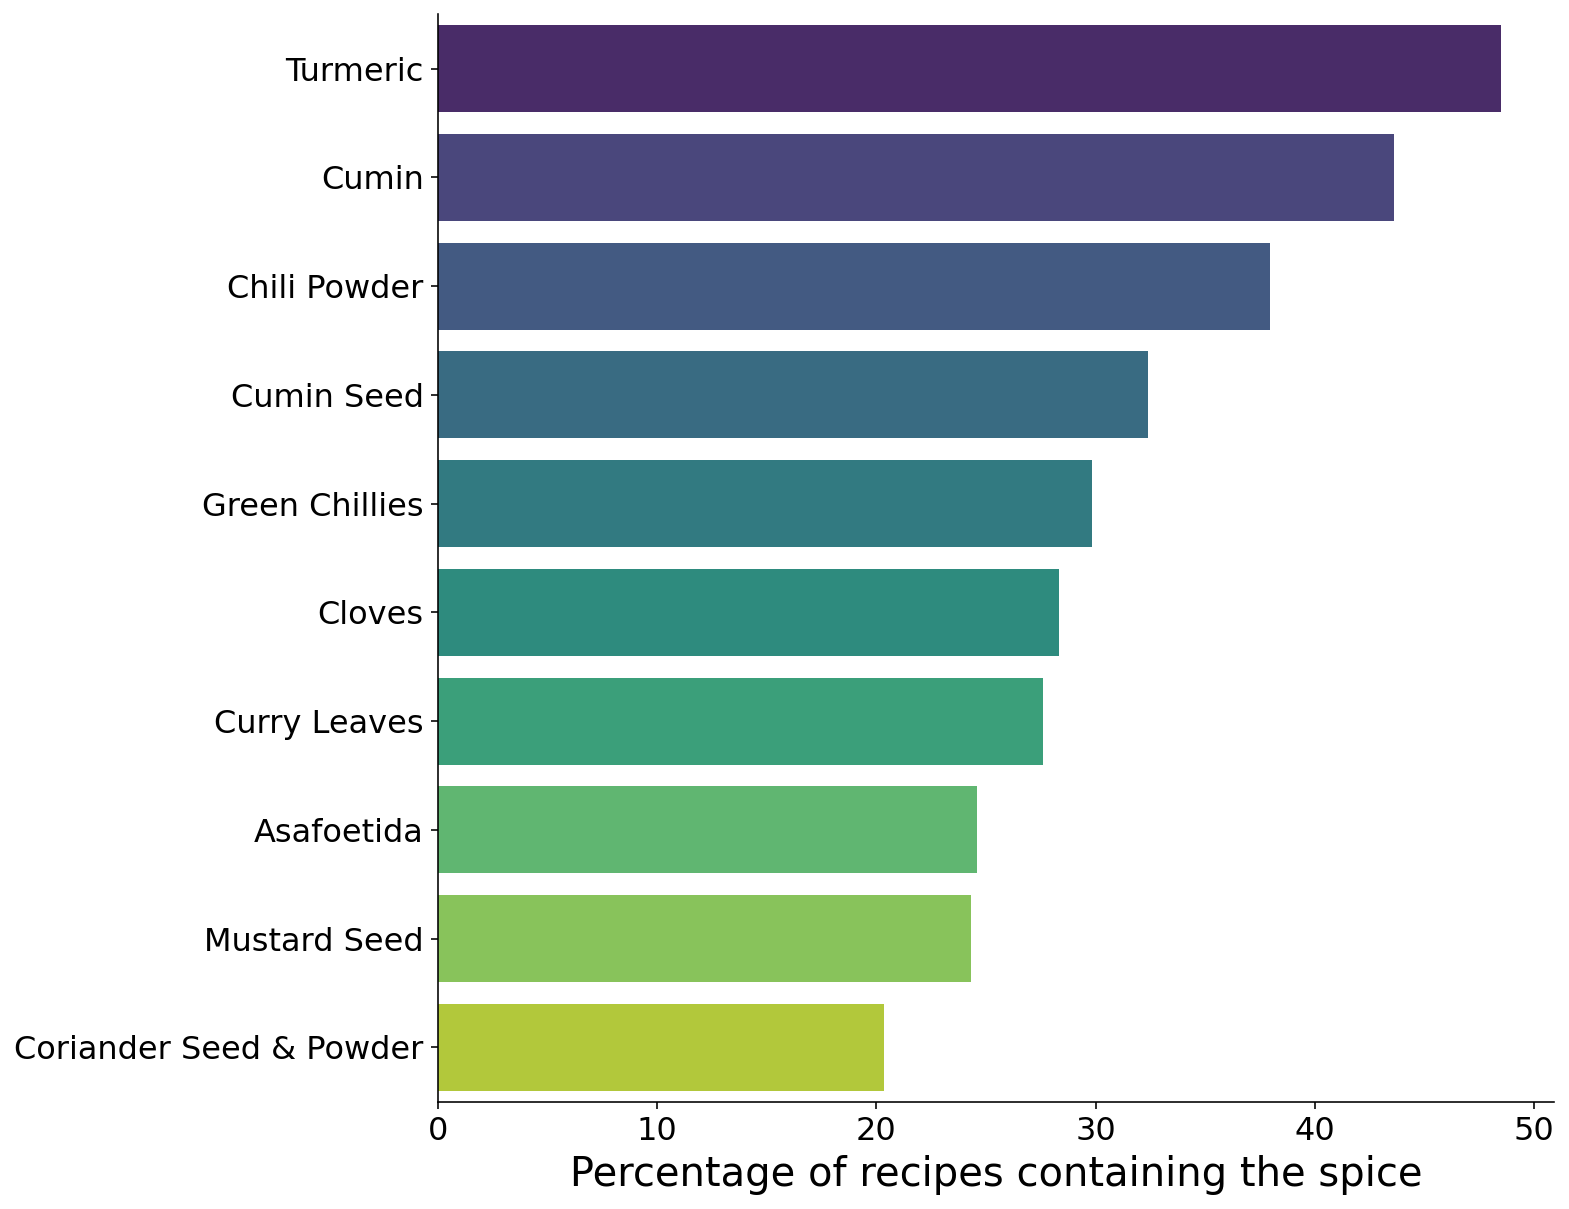

In [31]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.barplot(x="Percentage", y="plot_name", data=spice_freq_df, orientation = 'horizontal', palette='viridis', ax=ax)
sns.despine()
ax.set_ylabel('')
ax.set_xlabel('Percentage of recipes containing the spice')